In [49]:
import numpy as np

# for some data and preprocessing
from sklearn.datasets import load_diabetes, fetch_california_housing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# for printing stuff
# these are not necessary for running the learning process, just viewing the results
import pandas as pd
import matplotlib.pyplot as plt

# Load some data

In [2]:
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html
data = fetch_california_housing()
print(data['DESCR'])
print(data['feature_names'])
x_data = data['data']
y_data = data['target'].reshape((-1, 1))

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [7]:
# df_data = fetch_california_housing(as_frame=True).frame
# df_data.describe()

# Select train and test

In [13]:
num_samples = x_data.shape[0]
indices = np.random.permutation(num_samples)

train_percent = 0.8
train_size = int(train_percent * num_samples)

train_indices = indices[:train_size]
test_indices = indices[train_size:]

In [14]:
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(x_data[train_indices])
X_test = x_scaler.transform(x_data[test_indices])

y_scaler = StandardScaler()
Y_train = y_scaler.fit_transform(y_data[train_indices])
Y_test = y_scaler.transform(y_data[test_indices])

print(f'train shapes, X: {X_train.shape}, Y: {Y_train.shape}')
print(f'test shapes, X: {X_test.shape}, Y: {Y_test.shape}')

train shapes, X: (16512, 8), Y: (16512, 1)
test shapes, X: (4128, 8), Y: (4128, 1)


# Declare some things

In [5]:
def sigmoid(t):
    return 1 / (1 + np.exp(-t))

def sigmoid_derivative(t):
    return t * (1 - t)

In [7]:
num_input_features = x_data.shape[1] # number of features

In [29]:
layer_1_out_dim = 50
layer_2_out_dim = 25
layer_3_out_dim = 1

learning_rate = 0.001

# Declare weights

In [86]:
W_1 = np.random.normal(size=(num_input_features, layer_1_out_dim))
b_1 = np.zeros((1, layer_1_out_dim))

W_2 = np.random.normal(size=(layer_1_out_dim, layer_2_out_dim))
b_2 = np.zeros((1, layer_2_out_dim))

W_3 = np.random.normal(size=(layer_2_out_dim, layer_3_out_dim))
b_3 = np.zeros((1, layer_3_out_dim))

# Forward pass

In [87]:
A_0 = x_data

Z_1 = np.matmul(A_0, W_1) + b_1
A_1 = sigmoid(Z_1)

Z_2 = np.matmul(A_1, W_2) + b_2
A_2 = sigmoid(Z_2)

Z_3 = np.matmul(A_2, W_3) + b_3
A_3 = Z_3 # linear transform

y_hat = A_3

# Backward pass
- bias updates left explicity multiplied by a vector of ones for demonstration
    - swap to <code>np.sum()</code> in implementaion

In [88]:
loss = np.mean(np.square(y_data - y_hat))
print(f'loss: {loss}')

num_batch_rows = y_hat.shape[0]

dL_dZ_3 = -(2/num_batch_rows)*(y_data.reshape((-1, 1)) - y_hat)*1
dL_dZ_2 = np.matmul(dL_dZ_3, W_3.T) * sigmoid_derivative(Z_2) # element wise times the derivative
dL_dZ_1 = np.matmul(dL_dZ_2, W_2.T) * sigmoid_derivative(Z_1) # element wise times the derivative

# dZ_3_dW_3 = A_2, dZ_3_db_3 = 1
W_3 = W_3 - learning_rate*np.matmul(A_2.T, dL_dZ_3)
b_3 = b_3 - learning_rate*np.matmul(np.ones((1, num_batch_rows)), dL_dZ_3) # this can be done with a sum too

# dZ_2_dW_2 = A_1, dZ_2_db_2 = 1
W_2 = W_2 - learning_rate*np.matmul(A_1.T, dL_dZ_2)
b_2 = b_2 - learning_rate*np.matmul(np.ones((1, num_batch_rows)), dL_dZ_2)

# dZ_1_dW_1 = A_0, dZ_1_db_1 = 1
W_1 = W_1 - learning_rate*np.matmul(A_0.T, dL_dZ_1)
b_1 = b_1 - learning_rate*np.matmul(np.ones((1, num_batch_rows)), dL_dZ_1)

loss: 29616.055187296355


In [89]:
np.sum(dL_dZ_2, axis=0, keepdims=True).shape, b_2.shape

((1, 25), (1, 25))

In [55]:
W_1.shape, b_1.shape, W_2.shape, b_2.shape, W_3.shape, b_3.shape

((10, 50), (1, 50), (50, 25), (1, 25), (25, 1), (1, 1))

# Put it all together

### Hyper parameters

In [34]:
num_input_features = X_train.shape[1] # number of features
layer_1_out_dim = 8
layer_2_out_dim = 4
layer_3_out_dim = 1

learning_rate = 0.01
num_epochs = 1000

start_learning_rate = 0.01
end_learning_rate = 0.001

In [35]:
# glorot uniform (code from gpt)
def initialize_weights(input_size, output_size):
    # Glorot uniform initialization
    limit = np.sqrt(6 / (input_size + output_size))
    weights = np.random.uniform(-limit, limit, (input_size, output_size))
    return weights

# exponential decay (code from gpt)
def exponential_decay(start_lr, end_lr, decay_steps, current_epoch):
    decay_rate = (end_lr / start_lr) ** (1 / decay_steps)
    current_lr = start_lr * (decay_rate ** current_epoch)
    return current_lr

In [36]:
def sigmoid(t):
    return 1 / (1 + np.exp(-t))

def sigmoid_derivative(t):
    return t * (1 - t)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

### Declare weights
- can append 1's onto inputs to each layer to make calcs easier and drop explicit bias declaration

In [37]:
# naive weight declaration
# W_1 = np.random.normal(size=(num_input_features, layer_1_out_dim))
# b_1 = np.zeros((1, layer_1_out_dim))

# W_2 = np.random.normal(size=(layer_1_out_dim, layer_2_out_dim))
# b_2 = np.zeros((1, layer_2_out_dim))

# W_3 = np.random.normal(size=(layer_2_out_dim, layer_3_out_dim))
# b_3 = np.zeros((1, layer_3_out_dim))

In [38]:
W_1 = initialize_weights(num_input_features, layer_1_out_dim)
b_1 = np.zeros((1, layer_1_out_dim))

W_2 = initialize_weights(layer_1_out_dim, layer_2_out_dim)
b_2 = np.zeros((1, layer_2_out_dim))

W_3 = initialize_weights(layer_2_out_dim, layer_3_out_dim)
b_3 = np.zeros((1, layer_3_out_dim))

### Training loop
- batch size is all data

In [39]:
for i in range(num_epochs):
    # this could be done outside of the loop, but I'll leave it here in case batching is added
    num_batch_rows = X_train.shape[0]
    
    ########################
    # forward pass
    ########################
    A_0 = X_train # this could be moved

    Z_1 = np.matmul(A_0, W_1) + b_1
    A_1 = relu(Z_1)

    Z_2 = np.matmul(A_1, W_2) + b_2
    A_2 = relu(Z_2)

    Z_3 = np.matmul(A_2, W_3) + b_3
    A_3 = Z_3 # linear transform

    y_hat = A_3
    
    ########################
    # calculate loss
    ########################
    if (i+1) % 100 == 0:
        loss = np.mean(np.square(Y_train.reshape((-1, 1)) - y_hat))
        
        _A_0 = X_test # this could be moved
        _Z_1 = np.matmul(_A_0, W_1) + b_1
        _A_1 = relu(_Z_1)

        _Z_2 = np.matmul(_A_1, W_2) + b_2
        _A_2 = relu(_Z_2)

        _Z_3 = np.matmul(_A_2, W_3) + b_3
        _A_3 = _Z_3 # linear transform

        _y_hat = _A_3

        test_loss = np.mean(np.square(Y_test.reshape((-1, 1)) - _y_hat))
        
        print(f'epoch: {i+1}/{num_epochs}, train loss: {loss}, test loss: {test_loss}')
    
    # current_learning_rate = exponential_decay(start_learning_rate, end_learning_rate, num_epochs, i)
    current_learning_rate = learning_rate
    ########################
    # backward pass
    ########################
    # can also do: dL_dZ_3 = -(Y_train.reshape((-1, 1)) - y_hat)
    dL_dZ_3 = -(2/num_batch_rows)*(Y_train.reshape((-1, 1)) - y_hat)
    # dL_dZ_3 = -(Y_train.reshape((-1, 1)) - y_hat)
    dL_dZ_2 = np.matmul(dL_dZ_3, W_3.T) * relu_derivative(Z_2)
    dL_dZ_1 = np.matmul(dL_dZ_2, W_2.T) * relu_derivative(Z_1)

    # dZ_3_dW_3 = A_2, dZ_3_db_3 = 1
    W_3 = W_3 - current_learning_rate*np.matmul(A_2.T, dL_dZ_3)
    b_3 = b_3 - current_learning_rate*np.sum(dL_dZ_3, axis=0, keepdims=True)

    # dZ_2_dW_2 = A_1, dZ_2_db_2 = 1
    W_2 = W_2 - current_learning_rate*np.matmul(A_1.T, dL_dZ_2)
    b_2 = b_2 - current_learning_rate*np.sum(dL_dZ_2, axis=0, keepdims=True)

    # dZ_1_dW_1 = A_0, dZ_1_db_1 = 1
    W_1 = W_1 - current_learning_rate*np.matmul(A_0.T, dL_dZ_1)
    b_1 = b_1 - current_learning_rate*np.sum(dL_dZ_1, axis=0, keepdims=True)
    

epoch: 100/1000, train loss: 0.8238969658409241, test loss: 0.7846986325266602
epoch: 200/1000, train loss: 0.6340048321743992, test loss: 0.5819788640794358
epoch: 300/1000, train loss: 0.5255881336307033, test loss: 0.478291862830572
epoch: 400/1000, train loss: 0.4899620941496603, test loss: 0.44851799398465764
epoch: 500/1000, train loss: 0.4686053642022541, test loss: 0.429922486662364
epoch: 600/1000, train loss: 0.45119233880793824, test loss: 0.4144317664731839
epoch: 700/1000, train loss: 0.4360576291221356, test loss: 0.40134692195425387
epoch: 800/1000, train loss: 0.4227569190379417, test loss: 0.39010862790116907
epoch: 900/1000, train loss: 0.41145278374495503, test loss: 0.3808519030044625
epoch: 1000/1000, train loss: 0.402029950378928, test loss: 0.37323740801128547


In [40]:
A_0 = X_test # this could be moved

Z_1 = np.matmul(A_0, W_1) + b_1
A_1 = relu(Z_1)

Z_2 = np.matmul(A_1, W_2) + b_2
A_2 = relu(Z_2)

Z_3 = np.matmul(A_2, W_3) + b_3
A_3 = Z_3 # linear transform

y_hat = A_3

loss = np.mean(np.square(Y_test.reshape((-1, 1)) - y_hat))
print(f'final test loss: {loss}')

final test loss: 0.37316913515807787


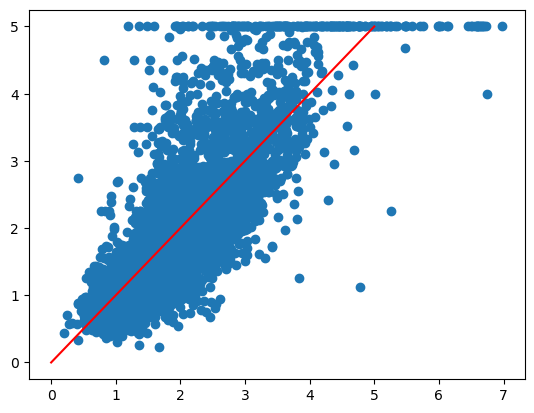

In [52]:
y_pred = y_scaler.inverse_transform(y_hat).flatten()
y_test = y_data[test_indices].flatten()

# pd.DataFrame({'y_pred': y_pred, 'y_true': y_test}).head()
plt.scatter(y_pred, y_test)

x_line = np.linspace(0, int(np.round(np.max(y_test))), 100)
y_line = x_line
plt.plot(x_line, y_line, color='r')

# Simple test with tensorflow and keras
- code from gpt

In [30]:
# from sklearn.datasets import fetch_california_housing
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# # Load the Boston Housing dataset
# ca_housing = fetch_california_housing()

# # Get the features and target
# X, y = ca_housing.data, ca_housing.target

# # Preprocess the data - scaling features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Build a simple neural network model
# model = Sequential()
# model.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1))  # Output layer - no activation function for regression

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


In [31]:
# y_pred = model.predict(X_test)

# pd.DataFrame({'y_pred': y_pred.flatten(), 'y_true': y_test.flatten()}).head()

# plt.scatter(y_pred, y_test)